# FET445 – Veri Madenciliği  
## Mustafa Türkmen – Temel Model Geliştirme (Özellik Seçimi + Boyut İndirgeme)

Bu notebook, **Depression Dataset** üzerinde çalışarak:

- Ortak veri keşfi (EDA) ve ön işleme adımlarını,
- Mustafa'nın sorumlu olduğu **özellik seçimi (Feature Selection)** tekniklerini,
- **Boyut indirgeme (Dimensionality Reduction)** adımlarını,
- Ve bunların farklı **temel (base) modeller üzerindeki etkisini** göstermektedir.

Hedef değişken (**target**): `History of Mental Illness`  
Görev türü: **İkili sınıflandırma (binary classification)**.


## 1. Problem Tanımı

Bu projede amaç, bireylerin yaşam tarzı, demografik özellikleri ve sağlık durumları gibi
değişkenleri kullanarak, geçmişte herhangi bir psikolojik rahatsızlık yaşayıp yaşamadıklarını
tahmin etmektir.

Bu notebook'ta **Mustafa'nın katkısı**:

- Ortak veri ön işleme pipeline'ının kullanılması,
- Farklı **özellik seçimi** tekniklerinin denenmesi:
  - `VarianceThreshold`
  - `SelectKBest(f_classif)`
- `PCA` ile boyut indirgeme,
- İki temel modelin kullanılması:
  - K-En Yakın Komşu (`KNeighborsClassifier`)
  - Gaussian Naive Bayes (`GaussianNB`),
- Ve tüm aşamalar için **performans karşılaştırması** yapılmasıdır.


## 2. Kurulum ve Gerekli Kütüphaneler

Bu bölümde veri işleme, modelleme ve değerlendirme için gerekli Python kütüphaneleri yüklenmektedir.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


## 3. Veri Setini Yükleme

Bu projede Kaggle üzerinde yer alan **Depression Dataset** kullanılmaktadır.  
Lütfen aynı klasörde veri dosyasının adını uygun şekilde ayarlayın.

- Önerilen dosya adı: `depression_data.csv` veya `depression-dataset.csv`
- Hedef sütun: `History of Mental Illness`


In [2]:
# Dosya yolu ve hedef sütun adı
CSV_PATH = "depression_data.csv"  # Gerekirse burayı kendi dosya adınla değiştir
TARGET_COL = "History of Mental Illness"  # Kaggle veri setindeki orijinal sütun adı

# Veriyi oku
df = pd.read_csv(CSV_PATH)

# Hedef sütunu 0/1'e çeviriyoruz: No -> 0, Yes -> 1
df[TARGET_COL] = df[TARGET_COL].map({"No": 0, "Yes": 1})

# İsim sütunu (Name) modelleme için anlamlı değil, bu yüzden siliyoruz
# Böylece gereksiz yüksek kardinaliteli kategorik sütunu kaldırmış oluyoruz
df = df.drop(columns=["Name"])

print("Veri şekli (satır, sütun):", df.shape)
df.head()

Veri şekli (satır, sütun): (413768, 15)


,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 4. Veri Setinin Genel Özeti

Bu bölümde veri setinin temel yapısı incelenmektedir:
- Sütun isimleri ve veri tipleri
- Sayısal ve kategorik sütunların ayrımı


In [3]:
# Sütun bilgileri
print("Sütun tipleri:\n")
print(df.dtypes)

print("\nİlk 5 gözlem:")
df.head()



Sütun tipleri:

Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness         int64
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object

İlk 5 gözlem:


,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 5. Eksik Değer Analizi ve Hedef Değişkenin Dağılımı

Modelleme öncesi:
- Hangi sütunlarda eksik veri var?
- Hedef sınıflar dengeli mi, dengesiz mi?


Eksik değer sayıları:

Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

Hedef değişken dağılımı (adet):
History of Mental Illness
0    287943
1    125825
Name: count, dtype: int64

Hedef değişken dağılımı (oran):
History of Mental Illness
0    0.695904
1    0.304096
Name: proportion, dtype: float64


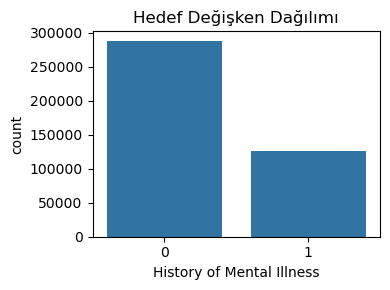

In [4]:
# Eksik değer sayıları
print("Eksik değer sayıları:\n")
print(df.isna().sum())

# Hedef değişken dağılımı
print("\nHedef değişken dağılımı (adet):")
print(df[TARGET_COL].value_counts())

print("\nHedef değişken dağılımı (oran):")
print(df[TARGET_COL].value_counts(normalize=True))

# İsteğe bağlı görselleştirme
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Hedef Değişken Dağılımı")
plt.tight_layout()
plt.show()


## 6. Özellik Türlerini Belirleme (Sayısal vs. Kategorik)

Makine öğrenmesi modelleri için sayısal ve kategorik sütunlara farklı ön işleme
adımları uygulanacaktır.

- Sayısal sütunlar: Ölçeklendirme (scaling)
- Kategorik sütunlar: One-Hot Encoding


In [5]:
# Özellik ve hedef ayrımı
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Sayısal ve kategorik sütunları otomatik bul
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Sayısal sütunlar:", num_cols)
print("Kategorik sütunlar:", cat_cols)


Sayısal sütunlar: ['Age', 'Number of Children', 'Income']
Kategorik sütunlar: ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


## 7. Ortak Ön İşleme Adımları (Preprocessing Pipeline)

Bu pipeline **tüm modeller** için ortaktır ve şu adımlardan oluşur:

- Sayısal sütunlar için:
  - Eksik değer doldurma (median)
  - Min-Max ölçeklendirme (0–1 aralığı)
- Kategorik sütunlar için:
  - Eksik değer doldurma (en sık görülen)
  - One-Hot Encoding


In [6]:
# Sayısal ve kategorik sütunlar için ayrı ön işleme adımları

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Sayısal eksik değer doldurma
    ("scaler", MinMaxScaler())                      # 0-1 aralığına ölçeklendirme
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Kategorik eksik değer doldurma
    # ÖNEMLİ: sparse_output=False -> One-Hot çıktısını dense (numpy array) yapar
    # Böylece GaussianNB gibi modellerle sorunsuz çalışır
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

## 8. Eğitim ve Test Kümesine Ayırma

Veri seti eğitim (train) ve test olarak ikiye ayrılacaktır.

- Test oranı: %20  
- Stratify: Hedef değişkenin sınıf dağılımını korumak için kullanılır.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)

print("Unique in y_train:", np.unique(y_train))
print("Unique in y_test:", np.unique(y_test))


Eğitim kümesi boyutu: (331014, 14)
Test kümesi boyutu: (82754, 14)
Unique in y_train: [0 1]
Unique in y_test: [0 1]


## 9. Değerlendirme Fonksiyonu

Tüm modeller için aynı değerlendirme fonksiyonu kullanılacaktır.

Hesaplanan metrikler:
- Doğruluk (Accuracy)
- F1 skoru
- ROC AUC (model olasılık tahmini veriyorsa)
- Sınıflandırma raporu ve karışıklık matrisi


In [8]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    # Verilen pipeline'i egitir ve temel siniflandirma metriklerini hesaplar.
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Bazı modeller predict_proba desteklemeyebilir
    auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

    # Karışıklık matrisi
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    }


## 10. Baz Modeller (Özellik Seçimi ve Boyut İndirgeme OLMADAN)

Bu bölümde ortak ön işleme adımlarını kullanarak, aşağıdaki iki temel model eğitilir:

- K-En Yakın Komşu (`KNeighborsClassifier`)
- Gaussian Naive Bayes (`GaussianNB`)

Bu sonuçlar, daha sonra **özellik seçimi** ve **boyut indirgeme** sonrası elde edilen performans
ile karşılaştırılacaktır.


=== Baz Model - KNN (k=5) ===
Accuracy: 0.6408270295091476
F1 Score: 0.2614853280989887
ROC AUC: 0.5359220987149782

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76     57589
           1       0.35      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.51     82754
weighted avg       0.60      0.64      0.61     82754



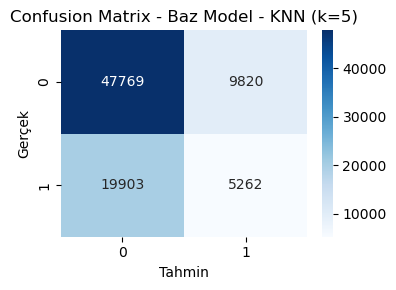

=== Baz Model - GaussianNB ===
Accuracy: 0.6324648959566909
F1 Score: 0.3714220761774857
ROC AUC: 0.590679958159907

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     57589
           1       0.39      0.36      0.37     25165

    accuracy                           0.63     82754
   macro avg       0.56      0.55      0.56     82754
weighted avg       0.62      0.63      0.63     82754



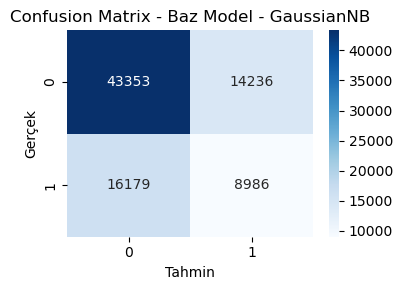

In [9]:
baseline_results = []

# 1) KNN (baseline)
knn_clf = KNeighborsClassifier(n_neighbors=5)

baseline_knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", knn_clf)
])

res_baseline_knn = evaluate_model(
    "Baz Model - KNN (k=5)",
    baseline_knn_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_knn)

# 2) Gaussian Naive Bayes (baseline)
gnb_clf = GaussianNB()

baseline_gnb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gnb_clf)
])

res_baseline_gnb = evaluate_model(
    "Baz Model - GaussianNB",
    baseline_gnb_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_gnb)


## 11. Mustafa – Özellik Seçimi (VarianceThreshold)

Bu bölümde Mustafa'nın sorumlu olduğu ilk özellik seçimi tekniği uygulanmaktadır:

- **Yöntem:** `VarianceThreshold`
- Amaç: Varyansı çok düşük olan (değişmeyen veya neredeyse sabit) özellikleri kaldırmak.

Bu teknik, özellikle yüksek boyutlu, sparse (One-Hot sonrası) verilerde
gereksiz sütunları elemeye yardımcı olur.

Seçilen özellikler ile tekrar:
- KNN
- GaussianNB

modelleri eğitilecek ve sonuçlar baz model ile karşılaştırılacaktır.


=== Mustafa - KNN + VarianceThreshold ===
Accuracy: 0.6408270295091476
F1 Score: 0.2614853280989887
ROC AUC: 0.5359220987149782

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76     57589
           1       0.35      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.51     82754
weighted avg       0.60      0.64      0.61     82754



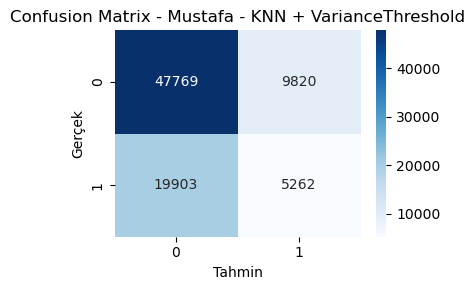

=== Mustafa - GaussianNB + VarianceThreshold ===
Accuracy: 0.6324648959566909
F1 Score: 0.3714220761774857
ROC AUC: 0.590679958159907

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     57589
           1       0.39      0.36      0.37     25165

    accuracy                           0.63     82754
   macro avg       0.56      0.55      0.56     82754
weighted avg       0.62      0.63      0.63     82754



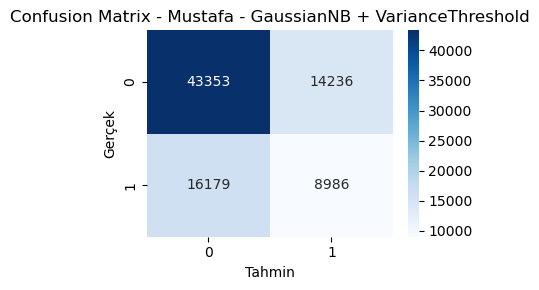

In [10]:
fs_results = []  # Mustafa'ya ait tüm FS/DR sonuçları burada toplanacak

# Varyansı çok düşük olan sütunları elemek için eşik (threshold)
var_threshold = 0.0  # Gerekirse 0.001 gibi değere yükseltilebilir
var_selector = VarianceThreshold(threshold=var_threshold)

# 1) KNN + VarianceThreshold
knn_var_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("var", var_selector),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

res_knn_var = evaluate_model(
    "Mustafa - KNN + VarianceThreshold",
    knn_var_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_knn_var)

# 2) GaussianNB + VarianceThreshold
gnb_var_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("var", var_selector),
    ("model", GaussianNB())
])

res_gnb_var = evaluate_model(
    "Mustafa - GaussianNB + VarianceThreshold",
    gnb_var_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_gnb_var)


## 12. Mustafa – Özellik Seçimi (SelectKBest – f_classif) + Boyut İndirgeme (PCA)

Bu bölümde ikinci özellik seçimi tekniği ve boyut indirgeme birlikte kullanılmaktadır:

- **Özellik Seçimi:** `SelectKBest(score_func=f_classif)`
- **Boyut İndirgeme:** `PCA`

Amaç:
- Önce hedef ile ilişkisi yüksek olan sütunları (ANOVA F-test) seçmek,
- Ardından PCA ile boyutu küçülterek gürültüyü azaltmak,
- Aynı iki modeli (KNN ve GaussianNB) bu yeni temsil üzerinde tekrar eğitmek.


=== Mustafa - KNN + SelectKBest(f_classif) + PCA ===
Accuracy: 0.6367305507890857
F1 Score: 0.2557437116260646
ROC AUC: 0.5293867137884251

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     57589
           1       0.34      0.21      0.26     25165

    accuracy                           0.64     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.64      0.61     82754



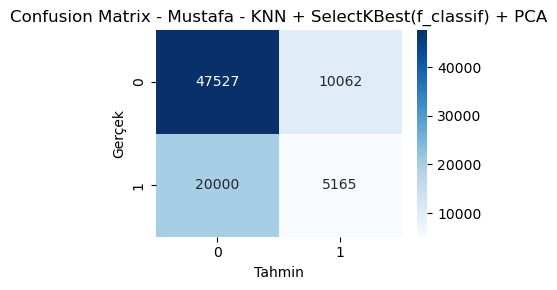

=== Mustafa - GaussianNB + SelectKBest(f_classif) + PCA ===
Accuracy: 0.6951688135920923
F1 Score: 0.013993120700437773
ROC AUC: 0.5903519909475063

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.43      0.01      0.01     25165

    accuracy                           0.70     82754
   macro avg       0.56      0.50      0.42     82754
weighted avg       0.61      0.70      0.57     82754



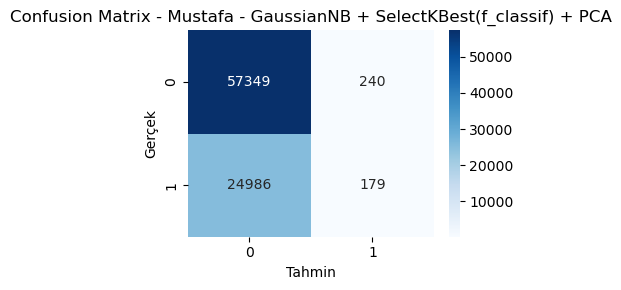

In [13]:
# Mustafa - SelectKBest(f_classif) + PCA denemeleri

# Seçilecek özellik sayısı
k_best = 20  # gerekirse değiştirilebilir
f_selector = SelectKBest(score_func=f_classif, k=k_best)

# PCA bileşen sayısı
n_pca_components = 10
pca = PCA(n_components=n_pca_components)

# 1) KNN + SelectKBest(f_classif) + PCA
knn_fs_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", f_selector),
    ("pca", pca),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

res_knn_fs_pca = evaluate_model(
    "Mustafa - KNN + SelectKBest(f_classif) + PCA",
    knn_fs_pca_pipeline,
    X_train, y_train,
    X_test, y_test
)

fs_results.append(res_knn_fs_pca)

# 2) GaussianNB + SelectKBest(f_classif) + PCA
gnb_fs_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", f_selector),
    ("pca", PCA(n_components=n_pca_components)),
    ("model", GaussianNB())
])

res_gnb_fs_pca = evaluate_model(
    "Mustafa - GaussianNB + SelectKBest(f_classif) + PCA",
    gnb_fs_pca_pipeline,
    X_train, y_train,
    X_test, y_test
)

fs_results.append(res_gnb_fs_pca)


## 13. Sonuçların Karşılaştırılması ve Özet Tablo

Aşağıdaki tabloda:
- Baz modeller
- VarianceThreshold ile özellik seçimi
- SelectKBest(f_classif) + PCA

sonrasında elde edilen metrikler yan yana gösterilmekte ve Mustafa'nın katkısı özetlenmektedir.


In [14]:
all_results = []

for r in baseline_results:
    r2 = r.copy()
    r2["kategori"] = "Baz Model"
    all_results.append(r2)

for r in fs_results:
    r2 = r.copy()
    r2["kategori"] = "Mustafa - FS/DR"
    all_results.append(r2)

results_df = pd.DataFrame(all_results)
results_df


,name,accuracy,f1,auc,kategori
0,Baz Model - KNN (k=5),0.640827,0.261485,0.535922,Baz Model
1,Baz Model - GaussianNB,0.632465,0.371422,0.590680,Baz Model
2,Mustafa - KNN + VarianceThreshold,0.640827,0.261485,0.535922,Mustafa - FS/DR
3,Mustafa - GaussianNB + VarianceThreshold,0.632465,0.371422,0.590680,Mustafa - FS/DR
4,Mustafa - KNN + SelectKBest(f_classif) + PCA,0.636731,0.255744,0.529387,Mustafa - FS/DR
5,Mustafa - GaussianNB + SelectKBest(f_classif) ...,0.695169,0.013993,0.590352,Mustafa - FS/DR


Bu tablo, projedeki **Mustafa** bileşeninin raporda kullanılacak olan
"base model performans karşılaştırması" kısmında doğrudan referans olarak kullanılabilir.

Rapor tarafında:
- Hangi özellik seçimi tekniğinin hangi modelde nasıl etki ettiği,
- PCA'nin özellikle KNN ve GaussianNB üzerindeki etkisi,
kısaca yorumlanmalıdır.
